In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from torch.utils.data import DataLoader
from torchmetrics.functional import peak_signal_noise_ratio, structural_similarity_index_measure
from imagenet_torch import ImageNet1000
from smoothened_estimate import SmoothenedModel
from evaluate_adv import seek_perturbation

In [6]:
os.chdir('/faidra/project')
test_data = ImageNet1000('./imagenet-mini/val', scaling_factor=2, use_cache=True)
test_dataloader = DataLoader(
    test_data, batch_size=128, pin_memory=True, shuffle=False)

device = 'cuda:2'

lr, hr = test_data[0]
# the dimensionality is later used to scale the adversarial perturbations.
#print(lr.shape)
n = np.prod(lr.shape)

# will be multiplied by math.sqrt(n), where n is the image dimension (e.g. 3*32*32)
eps_rel = 0.1
# number of PGD iterations; with value 1 it is a variant of FastFGSM (not necessarily sufficiently strong attack)
adv_iterations = 10

# specific attack settings defined below
# needs to be adapted for different settings (e.g. for classification one usually needs restarts and more iterations)
eps = eps_rel * math.sqrt(n) # eps_rel * 277
attack_kwargs01 = {
    'constraint': "2",
    'eps': eps,
    'step_size': 2.5 * (eps / adv_iterations),
    'iterations': adv_iterations,
    'random_start': True,
    'random_restarts': 0,
    'use_best': False,
    'random_mode': "uniform_in_sphere"
}

Loading dataset into cache...


In [17]:
sigmas_range = [0.01, 0.025, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5]
rs_base_model = torch.load('model_02_50.pt').to(device)

psnr_sigmas = []
ssim_sigmas = []

for sigma in sigmas_range:
    # evaluate on whole test set
    smoothing_model = SmoothenedModel(rs_base_model, sigma, device=device)
    normalize_inverse = transforms.Normalize(mean=[-0.4882/0.2777, -0.4431/0.2665, -0.3946/0.2739],
                                                std=[1/0.2777, 1/0.2665, 1/0.2739])
    mse_loss = nn.MSELoss()

    rs_base_model.eval()

    smooth_mse = []
    smooth_psnr = []
    smooth_ssim = []

    for idx, (low_img, high_img) in enumerate(test_dataloader):
        
        with torch.cuda.amp.autocast():
            low_img = low_img.to(device)
            high_img = high_img.to(device)

            rs_adv_perturbed_input, rs_base_model_pred = seek_perturbation(
                rs_base_model, low_img, high_img, make_adv=True, **attack_kwargs01)
            
            smooth = smoothing_model.smoothened_prediction(
                rs_adv_perturbed_input, num_e=100)
            
            mse_smooth = mse_loss(
                smooth.detach().cpu(), normalize_inverse(high_img).detach().cpu())
            smooth_mse.append(mse_smooth)
            psnr_smooth = peak_signal_noise_ratio(
                smooth.detach().cpu(), normalize_inverse(high_img).detach().cpu())
            smooth_psnr.append(psnr_smooth)
            ssim_smooth = structural_similarity_index_measure(
                smooth.detach().cpu(), normalize_inverse(high_img).detach().cpu())
            smooth_ssim.append(ssim_smooth)
        
    #print("MSE smooth:", sum(smooth_mse)/len(smooth_mse))
    psnr_sigmas.append(sum(smooth_psnr)/len(smooth_psnr))
    ssim_sigmas.append(sum(smooth_ssim)/len(smooth_ssim))

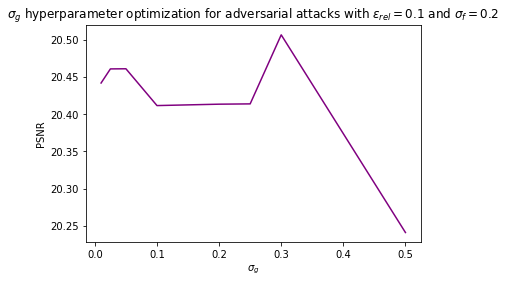

In [18]:
fig = plt.figure()

plt.title(r'$\sigma_{g}$' + f' hyperparameter optimization for adversarial attacks with' + r' $\epsilon_{rel}=$' + f'{eps_rel} and '+ r'$\sigma_{f}=0.2$')
plt.plot(sigmas_range, psnr_sigmas, c='purple')
plt.ylabel('PSNR')
plt.xlabel(r'$\sigma_{g}$')

plt.show()

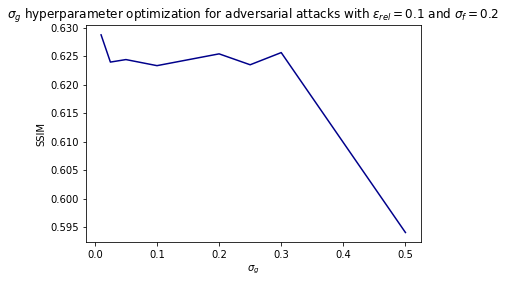

In [21]:
fig = plt.figure()

plt.title(r'$\sigma_{g}$' + f' hyperparameter optimization for adversarial attacks with' + r' $\epsilon_{rel}=$' + f'{eps_rel} and '+ r'$\sigma_{f}=0.2$')
plt.plot(sigmas_range[:8], ssim_sigmas[:8], c='darkblue')
plt.ylabel('SSIM')
plt.xlabel(r'$\sigma_{g}$')

plt.show()